# DMT Flow Curve Fitting

**de Souza Mendes–Thompson (DMT) thixotropic model — Steady-state flow curve**

## Learning Objectives

- Understand the DMT structural-kinetics model and its two viscosity closures
- Fit steady-state flow curves to real emulsion data using NLSQ
- Perform Bayesian inference with NUTS and evaluate convergence
- Compare exponential vs Herschel-Bulkley closures

## Prerequisites

- Basic familiarity with rheological flow curves σ(γ̇)
- Understanding of NLSQ fitting (see `01-basic-maxwell.ipynb`)
- Understanding of Bayesian inference basics (see `05-bayesian-basics.ipynb`)

## Estimated Runtime

- Fast demo (1 chain): ~2 min
- Full run (4 chains): ~5 min

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import DMTLocal

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


## 2. Theory: DMT Thixotropic Model

The DMT (de Souza Mendes–Thompson) model describes thixotropic materials using a scalar **structure parameter** $\lambda \in [0, 1]$:

- $\lambda = 1$: fully structured (at rest)
- $\lambda = 0$: fully broken (high shear)

### Structure kinetics

$$\frac{d\lambda}{dt} = \underbrace{\frac{1 - \lambda}{t_{\text{eq}}}}_{\text{aging}} - \underbrace{\frac{a \lambda |\dot{\gamma}|^c}{t_{\text{eq}}}}_{\text{breakdown}}$$

At steady state ($d\lambda/dt = 0$), the equilibrium structure is:

$$\lambda_{\text{eq}}(\dot{\gamma}) = \frac{1}{1 + a |\dot{\gamma}|^c}$$

### Viscosity closures

**Exponential closure** (4 parameters):

$$\eta(\lambda) = \eta_\infty \left(\frac{\eta_0}{\eta_\infty}\right)^\lambda$$

Steady-state stress: $\sigma = \eta(\lambda_{\text{eq}}) \cdot \dot{\gamma}$

**Herschel-Bulkley closure** (8 parameters):

$$\sigma = \tau_y(\lambda) + K(\lambda)|\dot{\gamma}|^n + \eta_\infty |\dot{\gamma}|$$

where $\tau_y(\lambda) = \tau_{y0}\lambda^{m_1}$ and $K(\lambda) = K_0\lambda^{m_2}$.

## 3. Load Data

We use a flow curve from a concentrated oil-in-water emulsion ($\phi = 0.80$). This system exhibits a clear yield stress and shear-thinning — ideal for DMT.

In [3]:
import os

data_path = os.path.join("..", "data", "flow", "emulsions", "0.80.csv")
if IN_COLAB:
    # Download from repository if running in Colab
    data_path = "0.80.csv"
    if not os.path.exists(data_path):
        print("Please upload 0.80.csv or adjust the path.")

raw = np.loadtxt(data_path, delimiter=",", skiprows=1)
gamma_dot = raw[:, 0]  # Shear rate [1/s]
stress = raw[:, 1]      # Stress [Pa]

print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.4f} – {gamma_dot.max():.1f} 1/s")
print(f"Stress range: {stress.min():.1f} – {stress.max():.1f} Pa")

Data points: 30
Shear rate range: 0.0016 – 978.9 1/s
Stress range: 23.7 – 295.4 Pa


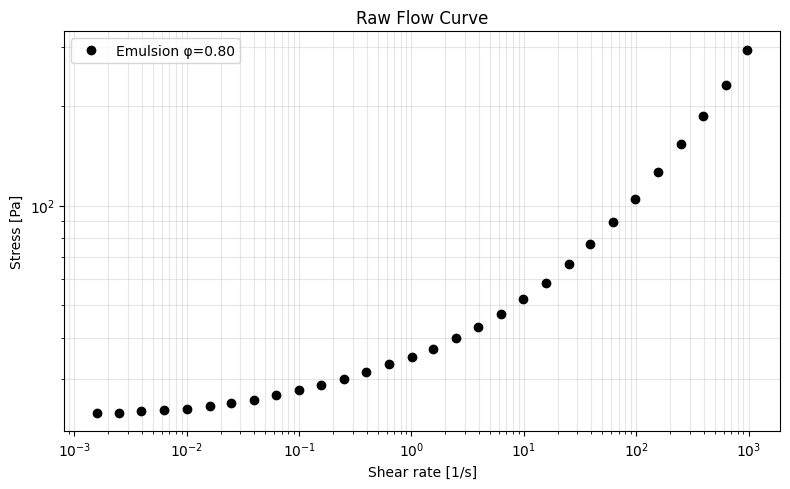

In [4]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Emulsion φ=0.80")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Raw Flow Curve")
ax.grid(True, alpha=0.3, which="both")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

The data shows a clear **yield stress plateau** at low shear rates (~24 Pa) transitioning to power-law shear-thinning at high rates. This is classic thixotropic behavior.

## 4. NLSQ Fitting

### 4.1 Exponential Closure

In [5]:
import time

# Helper function for computing fit quality
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

model_exp = DMTLocal(closure="exponential", include_elasticity=False)

# Set physically motivated bounds
model_exp.parameters["eta_0"].bounds = (1e2, 1e7)
model_exp.parameters["eta_inf"].bounds = (1e-2, 1e1)
model_exp.parameters["a"].bounds = (1e-3, 1e2)
model_exp.parameters["c"].bounds = (0.1, 2.0)

t0 = time.time()
model_exp.fit(gamma_dot, stress, test_mode="flow_curve", method="scipy")
t_nlsq_exp = time.time() - t0

# Predict and compute metrics
stress_pred = model_exp.predict(gamma_dot, test_mode="flow_curve")
metrics = compute_fit_quality(stress, stress_pred)

print(f"NLSQ fit time: {t_nlsq_exp:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4f} Pa")
print("\nFitted parameters (exponential closure):")
for name in ["eta_0", "eta_inf", "a", "c"]:
    val = model_exp.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4g}")

INFO:nlsq.curve_fit:Starting curve fit n_params=4 | n_data_points=30 | method=scipy | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.000069s


Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1582, in nlsq_curve_fit
    curve_fit_result = nlsq_module.curve_fit(
        f_wrapper, x_data_np, y_data_np, **curve_fit_kwargs
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 2500, in curve_fit
    result = jcf.curve_fit(f, xdata, ydata, *args, **kwargs)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 4360, in curve_fit
    res, jnp_xdata, ctime = self._run_optimization(
                            ~~~~~~~~~~~~~~~~~~~~~~^
        f,
        ^^
    ...<16 lines>...
        prepared_bounds=(_lb, _ub),
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 4023, in _run_optimization
    res = self.ls.least_squares(
        f_to_use,
    ...<11 lines>...
        **kwargs,


NLSQ fit time: 0.44 s
R²: 0.998033
RMSE: 2.9540 Pa

Fitted parameters (exponential closure):
  eta_0    = 1e+07
  eta_inf  = 0.01893
  a        = 1.677
  c        = 0.1892


### 4.2 Herschel-Bulkley Closure

In [6]:
model_hb = DMTLocal(closure="herschel_bulkley", include_elasticity=False)

t0 = time.time()
model_hb.fit(gamma_dot, stress, test_mode="flow_curve", method="scipy")
t_nlsq_hb = time.time() - t0

# Predict and compute metrics
stress_pred_hb = model_hb.predict(gamma_dot, test_mode="flow_curve")
metrics_hb = compute_fit_quality(stress, stress_pred_hb)

print(f"NLSQ fit time: {t_nlsq_hb:.2f} s")
print(f"R²: {metrics_hb['R2']:.6f}")
print(f"RMSE: {metrics_hb['RMSE']:.4f} Pa")
print("\nFitted parameters (HB closure):")
for name in model_hb.parameters.keys():
    if name in ["G0", "m_G"]:
        continue
    val = model_hb.parameters.get_value(name)
    print(f"  {name:8s} = {val:.4g}")

INFO:nlsq.curve_fit:Starting curve fit n_params=8 | n_data_points=30 | method=scipy | solver=auto | batch_size=None | has_bounds=True | dynamic_sizing=False


PERFORMANCE:nlsq.curve_fit:Timer: curve_fit elapsed=0.000017s


Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 1582, in nlsq_curve_fit
    curve_fit_result = nlsq_module.curve_fit(
        f_wrapper, x_data_np, y_data_np, **curve_fit_kwargs
    )
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 2500, in curve_fit
    result = jcf.curve_fit(f, xdata, ydata, *args, **kwargs)
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 4360, in curve_fit
    res, jnp_xdata, ctime = self._run_optimization(
                            ~~~~~~~~~~~~~~~~~~~~~~^
        f,
        ^^
    ...<16 lines>...
        prepared_bounds=(_lb, _ub),
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/nlsq/core/minpack.py", line 4023, in _run_optimization
    res = self.ls.least_squares(
        f_to_use,
    ...<11 lines>...
        **kwargs,


NLSQ fit time: 0.31 s
R²: 0.999676
RMSE: 1.1998 Pa

Fitted parameters (HB closure):
  eta_0    = 1e+05
  eta_inf  = 0.1368
  tau_y0   = 23.74
  K0       = 52.62
  n_flow   = 0.8989
  m1       = 0.5
  m2       = 0.5
  t_eq     = 100
  a        = 3.888
  c        = 1.268


### 4.3 Closure Comparison

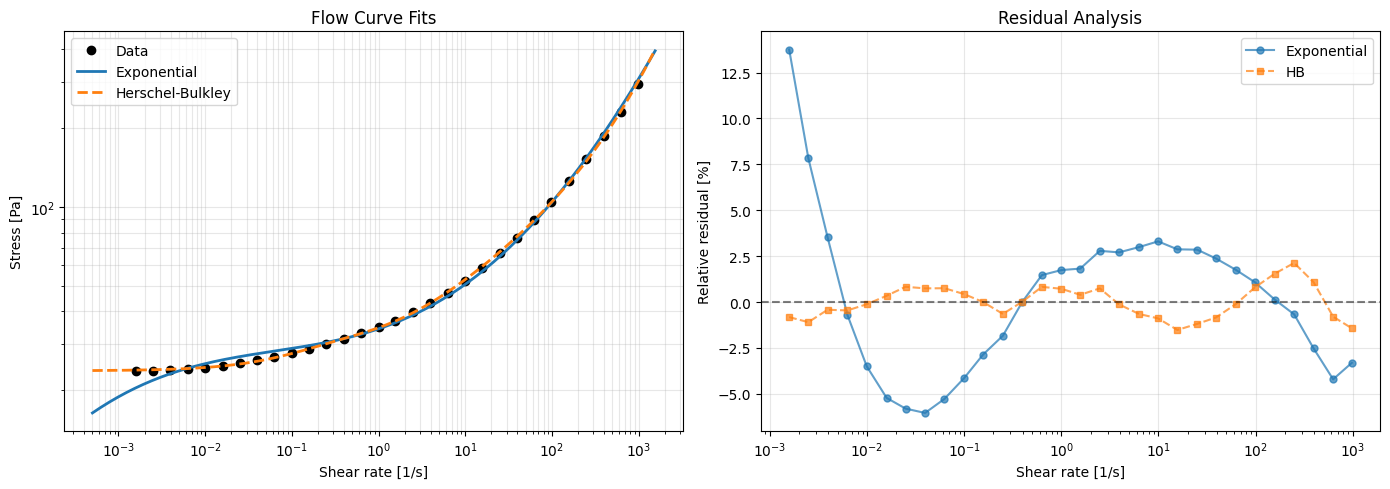

In [7]:
gamma_dot_fine = np.logspace(
    np.log10(gamma_dot.min()) - 0.5,
    np.log10(gamma_dot.max()) + 0.2,
    200,
)
stress_exp_pred = model_exp.predict(gamma_dot_fine)
stress_hb_pred = model_hb.predict(gamma_dot_fine)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: flow curves
ax1.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax1.loglog(gamma_dot_fine, stress_exp_pred, "-", lw=2, label="Exponential")
ax1.loglog(gamma_dot_fine, stress_hb_pred, "--", lw=2, label="Herschel-Bulkley")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Flow Curve Fits")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Right: residuals
stress_exp_at_data = model_exp.predict(gamma_dot)
stress_hb_at_data = model_hb.predict(gamma_dot)
res_exp = (stress - stress_exp_at_data) / stress * 100
res_hb = (stress - stress_hb_at_data) / stress * 100

ax2.semilogx(gamma_dot, res_exp, "o-", markersize=5, alpha=0.7, label="Exponential")
ax2.semilogx(gamma_dot, res_hb, "s--", markersize=5, alpha=0.7, label="HB")
ax2.axhline(0, color="black", linestyle="--", alpha=0.5)
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residual Analysis")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

### 4.4 Equilibrium Structure

The fitted parameters imply a shear-rate-dependent equilibrium structure $\lambda_{\text{eq}}(\dot{\gamma})$. This controls how much microstructure survives at each shear rate.

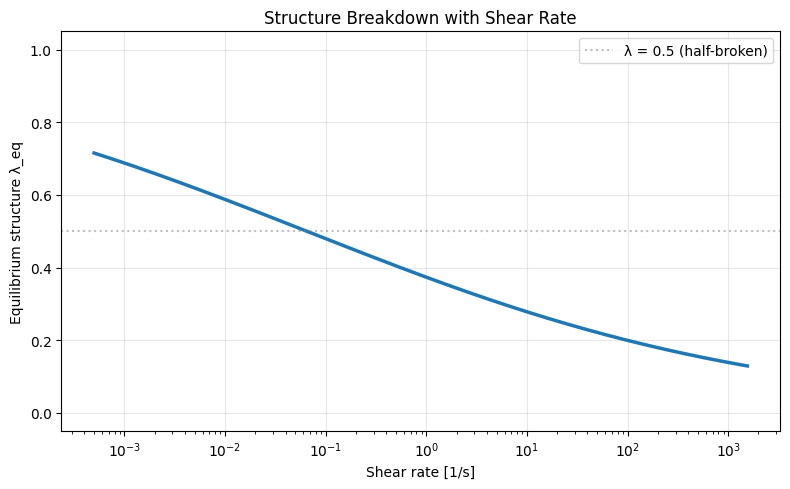

In [8]:
from rheojax.models.dmt._kernels import equilibrium_structure

a_fit = model_exp.parameters.get_value("a")
c_fit = model_exp.parameters.get_value("c")

lam_eq = equilibrium_structure(jnp.array(gamma_dot_fine), a_fit, c_fit)

fig, ax = plt.subplots(figsize=(8, 5))
ax.semilogx(gamma_dot_fine, np.array(lam_eq), "-", lw=2.5)
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Equilibrium structure λ_eq")
ax.set_title("Structure Breakdown with Shear Rate")
ax.set_ylim(-0.05, 1.05)
ax.grid(True, alpha=0.3)
ax.axhline(0.5, color="gray", linestyle=":", alpha=0.5, label="λ = 0.5 (half-broken)")
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Bayesian Inference with NUTS

We use the exponential closure for Bayesian inference (fewer parameters → better identifiability). The NLSQ estimates serve as warm-start for NUTS.

### 5.1 Run NUTS

In [9]:
# Warm-start values from NLSQ
initial_values = {
    name: model_exp.parameters.get_value(name)
    for name in model_exp.parameters.keys()
}
print("Warm-start values:", initial_values)

# --- Fast demo config (change to 4 chains for production) ---
NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model_exp.fit_bayesian(
    gamma_dot,
    stress,
    test_mode="flow_curve",
    num_warmup=NUM_WARMUP,
    num_samples=NUM_SAMPLES,
    num_chains=NUM_CHAINS,
    initial_values=initial_values,
    seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'eta_0': 9999999.999988481, 'eta_inf': 0.018934760647633497, 't_eq': 100.0, 'a': 1.677098147886746, 'c': 0.1891572998307313}



  0%|          | 0/700 [00:00<?, ?it/s]


warmup:   0%|          | 1/700 [00:00<04:03,  2.87it/s, 1 steps of size 1.65e+00. acc. prob=0.00]


warmup:   4%|▎         | 25/700 [00:00<00:09, 69.49it/s, 1023 steps of size 6.10e-04. acc. prob=0.85]


warmup:   6%|▌         | 41/700 [00:00<00:06, 95.14it/s, 1023 steps of size 9.48e-04. acc. prob=0.90]


warmup:   9%|▉         | 65/700 [00:00<00:04, 132.09it/s, 1023 steps of size 8.22e-04. acc. prob=0.92]


warmup:  12%|█▏        | 83/700 [00:00<00:04, 144.37it/s, 1023 steps of size 5.41e-04. acc. prob=0.93]


warmup:  14%|█▍        | 101/700 [00:00<00:03, 150.10it/s, 1023 steps of size 4.83e-03. acc. prob=0.94]


warmup:  17%|█▋        | 122/700 [00:00<00:03, 167.10it/s, 1023 steps of size 8.67e-03. acc. prob=0.95]


warmup:  23%|██▎       | 162/700 [00:01<00:02, 232.28it/s, 63 steps of size 4.27e-03. acc. prob=0.95]  


warmup:  29%|██▊       | 200/700 [00:01<00:01, 274.93it/s, 255 steps of size 6.63e-03. acc. prob=0.96]


sample:  33%|███▎      | 229/700 [00:01<00:01, 273.30it/s, 255 steps of size 6.63e-03. acc. prob=0.98]


sample:  38%|███▊      | 263/700 [00:01<00:01, 292.42it/s, 511 steps of size 6.63e-03. acc. prob=0.98]


sample:  42%|████▏     | 293/700 [00:01<00:01, 269.96it/s, 191 steps of size 6.63e-03. acc. prob=0.98]


sample:  46%|████▌     | 321/700 [00:01<00:01, 271.35it/s, 23 steps of size 6.63e-03. acc. prob=0.98] 


sample:  51%|█████▏    | 359/700 [00:01<00:01, 298.64it/s, 511 steps of size 6.63e-03. acc. prob=0.98]


sample:  56%|█████▌    | 390/700 [00:01<00:01, 254.62it/s, 255 steps of size 6.63e-03. acc. prob=0.97]


sample:  60%|██████    | 420/700 [00:02<00:01, 264.75it/s, 511 steps of size 6.63e-03. acc. prob=0.97]


sample:  65%|██████▌   | 457/700 [00:02<00:00, 292.21it/s, 511 steps of size 6.63e-03. acc. prob=0.97]


sample:  70%|██████▉   | 488/700 [00:02<00:00, 295.89it/s, 255 steps of size 6.63e-03. acc. prob=0.97]


sample:  75%|███████▌  | 525/700 [00:02<00:00, 311.54it/s, 511 steps of size 6.63e-03. acc. prob=0.97]


sample:  80%|████████  | 560/700 [00:02<00:00, 321.16it/s, 255 steps of size 6.63e-03. acc. prob=0.97]


sample:  85%|████████▍ | 593/700 [00:02<00:00, 291.25it/s, 159 steps of size 6.63e-03. acc. prob=0.97]


sample:  89%|████████▉ | 623/700 [00:02<00:00, 278.91it/s, 511 steps of size 6.63e-03. acc. prob=0.97]


sample:  93%|█████████▎| 652/700 [00:02<00:00, 259.49it/s, 255 steps of size 6.63e-03. acc. prob=0.97]


sample:  97%|█████████▋| 679/700 [00:02<00:00, 259.28it/s, 383 steps of size 6.63e-03. acc. prob=0.97]


sample: 100%|██████████| 700/700 [00:02<00:00, 235.23it/s, 31 steps of size 6.63e-03. acc. prob=0.97] 


Bayesian inference time: 5.3 s


### 5.2 Convergence Diagnostics

In [10]:
diag = result.diagnostics
param_names = ["eta_0", "eta_inf", "a", "c"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")

n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

# Quality check
r_hat_vals = [diag.get("r_hat", {}).get(p, 2.0) for p in param_names]
ess_vals = [diag.get("ess", {}).get(p, 0) for p in param_names]
if max(r_hat_vals) < 1.05 and min(ess_vals) > 100:
    print("\nConvergence: PASSED")
else:
    print("\nConvergence: CHECK REQUIRED (increase num_warmup/num_samples)")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
     eta_0    1.0000       500
   eta_inf    1.0000       500
         a    1.0000       500
         c    1.0000       500

Divergences: 0

Convergence: PASSED


### 5.3 ArviZ Diagnostic Plots

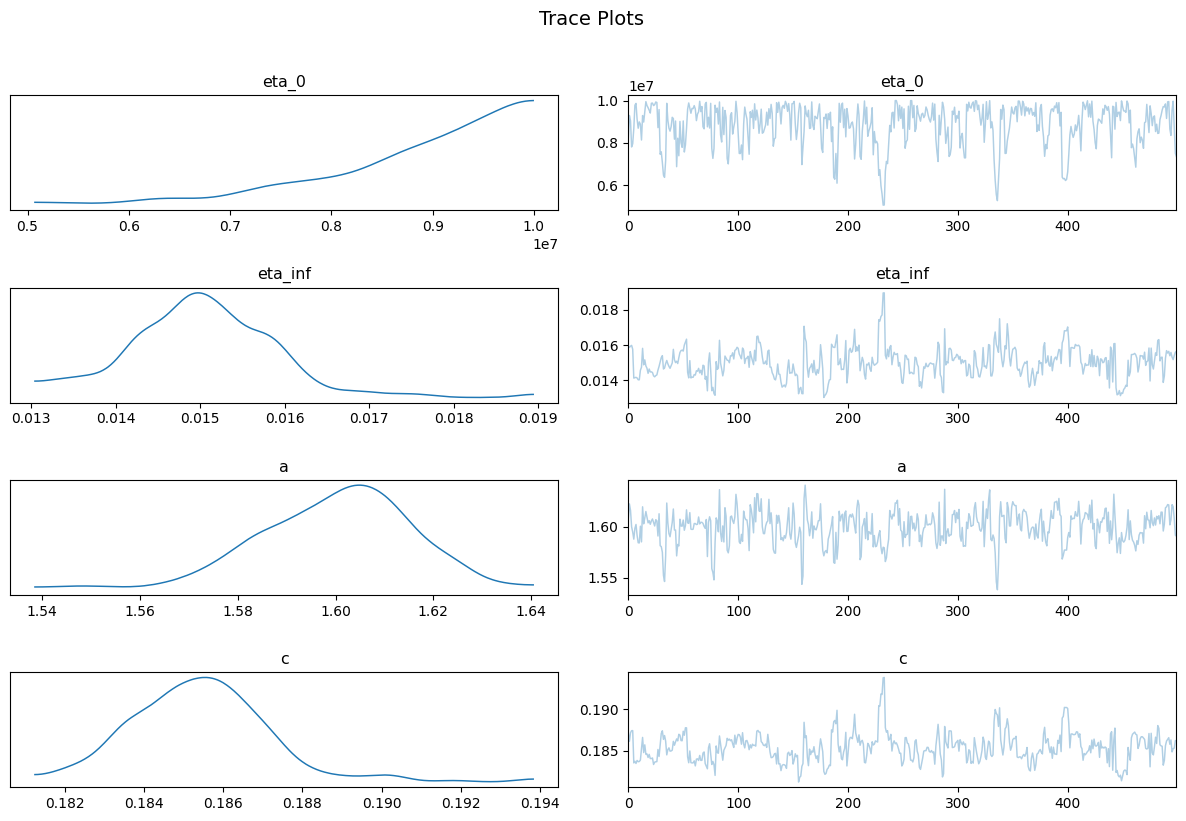

In [11]:
idata = result.to_inference_data()

# Trace plot
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 8))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

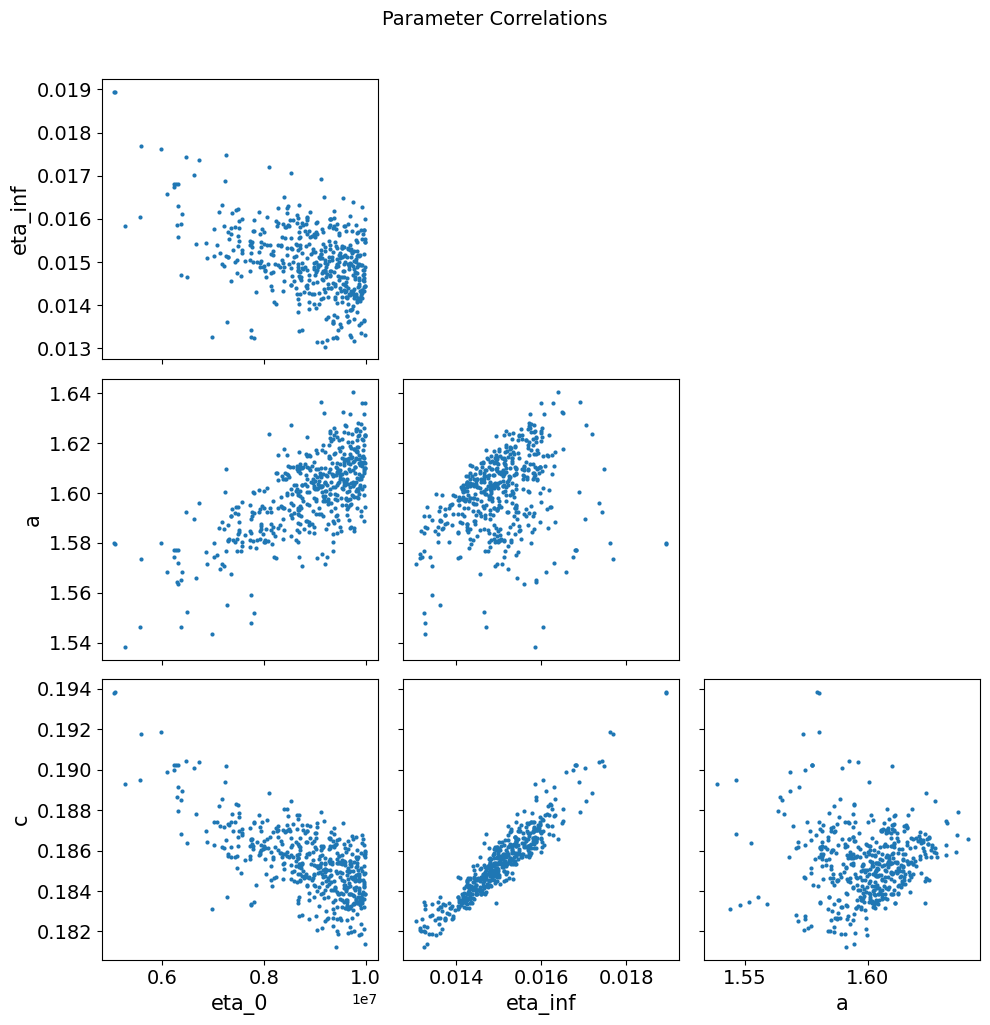

In [12]:
# Pair plot (parameter correlations)
axes = az.plot_pair(
    idata,
    var_names=param_names,
    kind="scatter",
    divergences=True,
    figsize=(10, 10),
)
fig = axes.ravel()[0].figure
fig.suptitle("Parameter Correlations", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

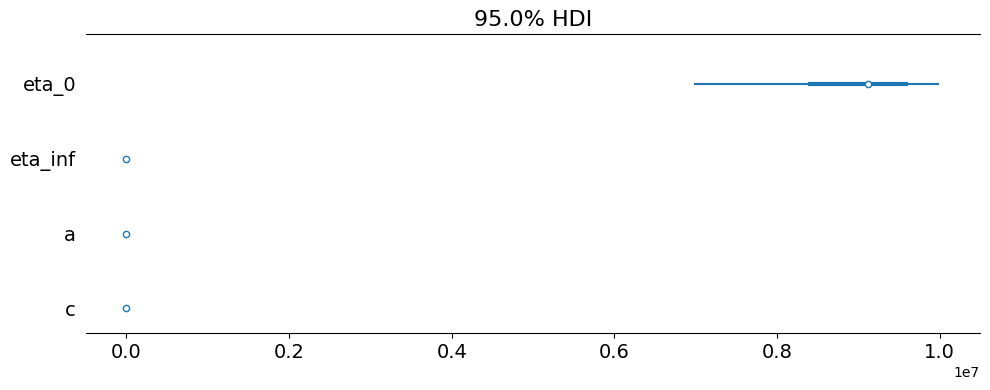

In [13]:
# Forest plot (credible intervals)
axes = az.plot_forest(
    idata,
    var_names=param_names,
    combined=True,
    hdi_prob=0.95,
    figsize=(10, 4),
)
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.4 Posterior Predictive Check

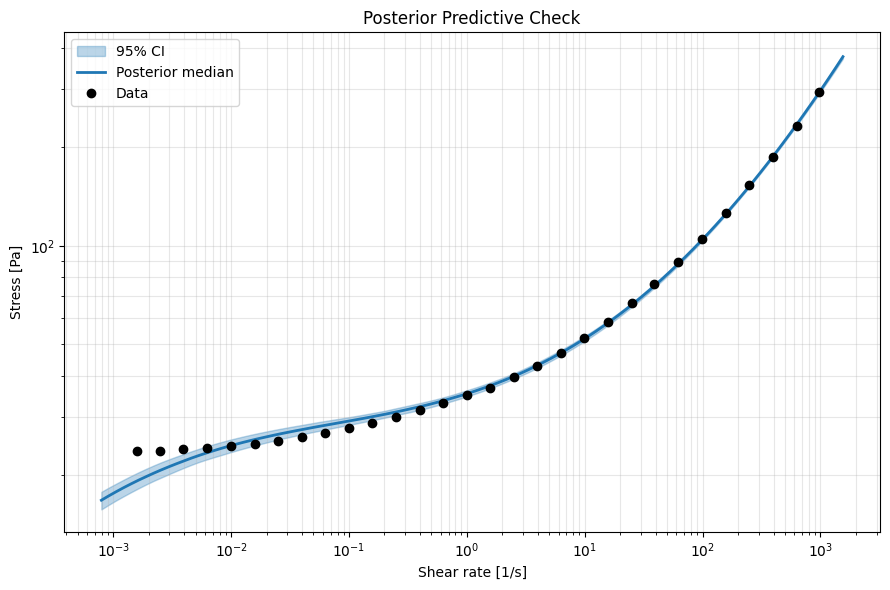

In [14]:
from rheojax.models.dmt._kernels import steady_stress_exponential

# Get credible intervals
intervals = model_exp.get_credible_intervals(
    result.posterior_samples, credibility=0.95
)

# Sample posterior predictions
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
gamma_dot_pred = jnp.logspace(
    np.log10(gamma_dot.min()) - 0.3,
    np.log10(gamma_dot.max()) + 0.2,
    100,
)

# Draw posterior predictive samples
pred_samples = []
param_names = ["eta_0", "eta_inf", "a", "c"]

for i in range(n_draws):
    # Set model parameters from posterior sample
    for name in param_names:
        model_exp.parameters.set_value(name, float(posterior[name][i]))
    
    # Predict using model.predict
    pred_i = model_exp.predict(gamma_dot_pred, test_mode="flow_curve")
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(
    gamma_dot_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI"
)
ax.loglog(gamma_dot_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(gamma_dot, stress, "ko", markersize=6, label="Data")
ax.set_xlabel("Shear rate [1/s]")
ax.set_ylabel("Stress [Pa]")
ax.set_title("Posterior Predictive Check")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 5.5 Parameter Summary

In [15]:
print("Parameter Comparison: NLSQ vs Bayesian")
print("=" * 60)
print(f"{'Param':>8s}  {'NLSQ':>12s}  {'Bayes median':>14s}  {'95% CI':>20s}")
print("-" * 60)

for name in param_names:
    nlsq_val = model_exp.parameters.get_value(name)
    bayes_samples = posterior[name]
    median = float(np.median(bayes_samples))
    lo = float(np.percentile(bayes_samples, 2.5))
    hi = float(np.percentile(bayes_samples, 97.5))
    print(f"{name:>8s}  {nlsq_val:12.4g}  {median:14.4g}  [{lo:.4g}, {hi:.4g}]")

Parameter Comparison: NLSQ vs Bayesian
   Param          NLSQ    Bayes median                95% CI
------------------------------------------------------------
   eta_0     9.621e+06       9.119e+06  [6.323e+06, 9.97e+06]
 eta_inf       0.01386         0.01499  [0.01331, 0.01681]
       a         1.595           1.602  [1.567, 1.626]
       c        0.1832          0.1854  [0.1822, 0.1897]


## 6. Common Failure Modes

| Issue | Symptom | Fix |
|-------|---------|-----|
| Poor NLSQ convergence | R² < 0.95 | Tighten bounds, increase max_iter |
| NUTS divergences | divergence warnings | Increase num_warmup, use warm-start |
| η₀ / η∞ at bounds | Parameter hits upper/lower limit | Widen bounds |
| a, c unidentifiable | Wide posteriors, low ESS | Normal for flow-curve-only data — combine with startup/creep |

## 7. Save Results

Save the calibrated exponential-closure parameters for use in Notebooks 02, 05, and 06 (which generate synthetic startup, SAOS, and LAOS data from these values).

In [16]:
import json

output_dir = os.path.join("..", "outputs", "dmt", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

# Save NLSQ point estimates
nlsq_params = {
    name: float(model_exp.parameters.get_value(name))
    for name in model_exp.parameters.keys()
}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

# Save posterior samples
posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")
print(f"  nlsq_params.json: {len(nlsq_params)} parameters")
print(f"  posterior_samples.json: {n_draws} draws")

Results saved to ../outputs/dmt/flow_curve/
  nlsq_params.json: 5 parameters
  posterior_samples.json: 200 draws


## Key Takeaways

1. **DMT captures yield stress + shear-thinning** via structure-dependent viscosity
2. **Exponential closure** uses 4 parameters; **HB closure** uses 8 — choose based on data resolution
3. **NLSQ warm-start is critical** for NUTS convergence on this model
4. **a and c** control structure breakdown kinetics — they may show correlations in the posterior
5. The **equilibrium structure** λ_eq(γ̇) provides physical insight into microstructural state

## Next Steps

- **Notebook 02**: Use these calibrated parameters to generate startup shear data and observe stress overshoot
- **Notebook 03**: Fit stress relaxation data from laponite clay
- **Notebook 04**: Fit creep data with viscosity bifurcation